# An Introduction to the `mcr` Library

This notebook is an overview to the `mcr` library for creating and studying the Minimum Constraint Removal (MCR) problem.

It is not an introduction to the problem itself. Please refer to Hauser's [introduction](https://pdfs.semanticscholar.org/153e/a4fb187bd0dbda27a51979ff8f09c478bf59.pdf) or the restriction of it to the plane [by Erickson and LaValle](https://pdfs.semanticscholar.org/5363/00838eeb4eefe9bde1cc9e105047f6ca554e.pdf?_ga=1.121233224.1753756452.1479176681) for more information; both are very readable.

In brief, the problem space is a number of shapes, called __obstacles__, which are placed on a __configuration space__, a square in the plane. They can overlap each other, many times over if wanted. If they overlap the borders of the configuration space, that part is ignored. In addition, there are two points, called the __start__ and __goal__ placed somewhere in the configuration space as well. The __cover__ of any point in the plane is the set of obstacles present at that point. A solution to the MCR problem finds the fewest number of obstacles which need to be removed for an unblocked path to be present between the start and goal.

![basic](basic.pdf)

We're not looking for a specific 2-D path through the plane, but rather a list of sections, overlapped or not, which we'll need to pass through—the MCR Problem is *discrete*. The problem can be applied to non-spatial instances; its name, "constraint" removal, hints at this.

Whether the full problem or the restricted, MCR is NP-hard.

## Setting Up Your Environment

Let's make the reasonable assumption that you have Jupyter running (as you're reading this in a Jupyter notebook right now!) and also that you have a recent version of Python, e.g., 3.6.

There are several libraries required by `mcr` that you'll need to install, for graphs (`networkx`), geometric operations (`shapely`), etc., and it's no help that these, like many Python mathematical libraries, are thin wrappers over C++ or Fortran code which need to be built, compiled, linked, etc. on your computer.

Don't do this from scratch: use [conda](https://conda.io/docs/). Download [Anaconda](https://www.continuum.io) or install conda yourself. The easiest thing to do is to create a new environment to load all this in, then load it, then run this again.

```bash
> conda create --name min_cover
> source activate min_cover
> conda install python=3.6
> conda update python
> conda install jupyter
> conda install pip
> conda install networkx
> pip install shapely
> ...etc.
```

We've created and entered a new environment, installed (if it's not already) and updated (if it's not already) Python, updated Jupyter, and begun to install all the other libraries. If you can't install something with `conda`, you probably can with `pip`.

This isn't a Python tutorial: let's press on.

## Setting Up the Notebook

We need to set up the Jupyter notebook to display figures properly and import our libraries. You may need to add more libraries; these are what's needed at minimum to run MCR and to easily use the component libraries.

In [1]:
# magic
%matplotlib inline

# TODO: comment each line
# imports - standard library
import random as rand
from math import *

# imports - standard for Jupyter
import matplotlib
import matplotlib.pyplot as plt

# imports - additional libraries
import networkx as nx
import shapely
from shapely.geometry import *
from shapely.affinity import *
from shapely.prepared import prep

# mcr
from mcr import *

# make inline figures large
from pylab import rcParams
rcParams['figure.figsize'] = (10, 10) # set this to (8, 8) for smaller output

Let's start by creating a configuration space by hand. A new MCR object does not have any obstacles in it, but it does have start- and endpoints at $(0.01, 0.01)$ and $(0.99, 0.99)$ respectively.

In [2]:
# Create an empty square
square = MCR()

# Add a couple of shapes to the square
shape1 = Polygon([(0.2,0.2), (0.2, 0.7), (0.7,0.7), (0.7,0.2)])
shape2 = Polygon([(0.5,0.15), (1.0,0.15), (.75, .87)])
shape3 = Polygon([(0.0, 0.2), (0.0, 0.5), (0.3, 0.5), (0.3,0.2)])

# change its color? Why not!?
shape1.facecolor = 'pink'

square.add_obstacle(shape1)
square.add_obstacle(shape2)
square.add_obstacle(shape3)

# Move the start and goal
square.start = Point(0.05, 0.05)
square.goal  = Point(0.95, 0.95)

Let's display this. Notice that the bounds of the configuration space are the unit square from $[0,0]$ to $[1,1]$. Any part of a shape which extends past this will be removed.

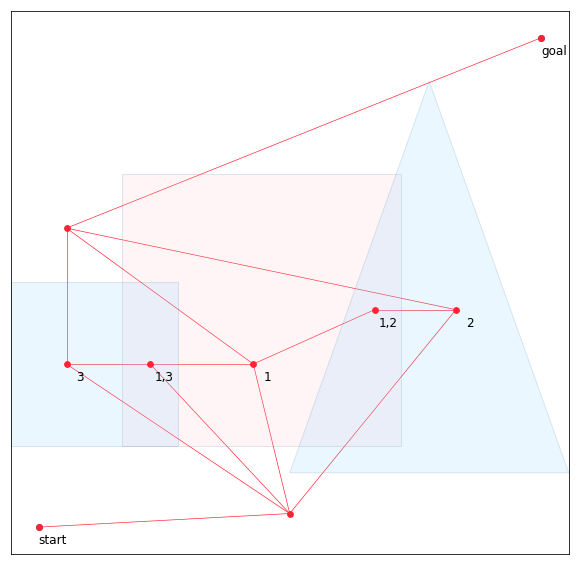

In [3]:
square.show(labels=True)

(Setting `labels=false` or ignoring it will not show labels.)

Each object has a label, whether it's shown or not. A graph is created, and each parts of the space, as represented by a node in this graph is labeled by the __cover__, the set of objects covering it.

## Loading from an SVG

Complicated configurations can be described most easily in pictures. `mcr` allows for creating MCR objects from SVG images. (Most vector graphics programs can output in SVG format, and it's human-readable as well.) Use the optional `svg=` argument in the constructor.

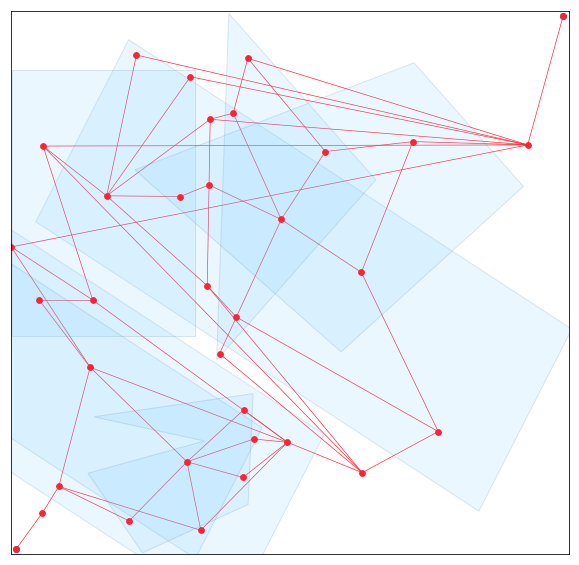

In [4]:
shapes = MCR(svg='shapes.svg')
shapes.show()

`shapes.show()` is equivalent to:
```python
shapes.plot_obstacles()
shapes.plot_graph(labels=False)
shapes.setup_axes()
plt.show()
```

There are nine SVG's included with this library, mostly for debugging purposes.

For more complicated displays, you'll need to do this yourself; that's okay, there are lots of primitives for drawing obstacles and graphs.

Note too that it's easy to change the default appearance of these renditions by setting `MCR.shape_opts`, `MCR.point_opts`, `MCR.nx_opts`, `MCR.featured_opts`, etc. Check the source code.

## Additional components

Besides the MCR class, there are a few helper methods in `mcr` for easily creating interesting configuration spaces. `random_MCR(n)` add $n$ randomly dispersed obstacles to a space.

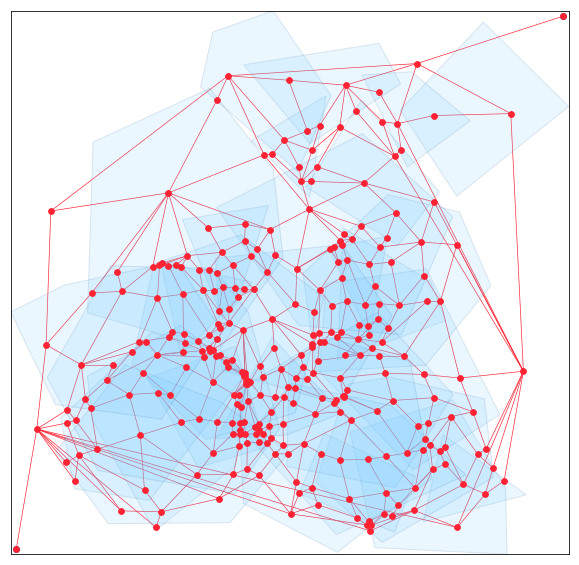

In [5]:
f = random_MCR(30)
f.show()

We can use our random MCR, f, to show how the drawing primitives `plot_obstacles`, `plot_shapes`, `plot_graph`, and `setup_axes` are used.

`plot_obstacles` add all the obstacles to the display.

`plot_shapes` is what `plot_obstacles` uses; in this case we'll use it to highlight the multiply-overlapped components.

`plot_graph` draws the graph.

`setup axes` makes the axes of what is actually a matplotlib graph look decent.

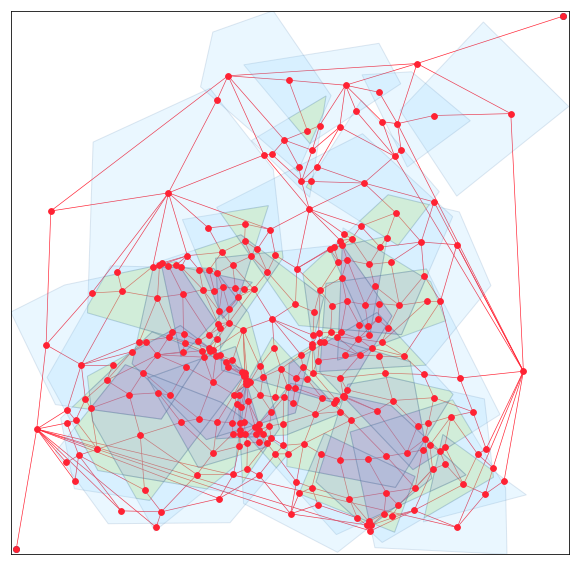

In [6]:
### highlight overlapping obstacles
multiples = [o_o for o_o in f.overlapped_obstacles if len(o_o.cover) >= 3]

# find the overlappings and mark them
for o_o in multiples:
    if len(o_o.cover) > 4:
        o_o.facecolor = 'red'
    elif len(o_o.cover) > 3:
        o_o.facecolor = 'orange'
    elif len(o_o.cover) > 2:
        o_o.facecolor = 'yellow'


# first draw everything
f.plot_obstacles()

MCR.plot_shapes(multiples)

# show the graph as well
f.plot_graph(labels=False)
f.setup_axes()
plt.show()

We can also highlight parts of the graph.

`plot_subgraph(path)` works exactly the same as `plot_graph`, but only for the path.

`shortest_covered_path(u, v, cover)` finds a shortest path.

`shortest_covered_paths(u, v, cover)` (not shown) finds *all* shortest paths between $u$ and $v$.

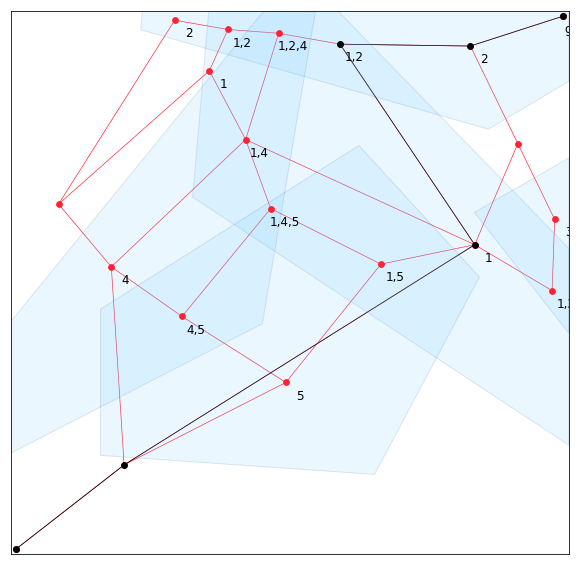

In [7]:
basic = MCR(svg='basic.svg')

# We determine the minimum cover is {1, 2} in some way
path = basic.shortest_covered_path(basic.start.wkt, basic.goal.wkt, cover=set([1,2]))

basic.plot_obstacles()
basic.plot_graph(labels=True)
basic.plot_subgraph(path)
MCR.setup_axes()
plt.show()

## Conclusion

This is a brief sampling of what the `mcr` library makes available for creating and display. Actually solving these is still up to you!

The library is [available on GitHub](https://github.com/Aarononomous/MCR), and in the [test notebook](https://github.com/Aarononomous/MCR/blob/master/mcr.ipynb), there are more examples of usage. Like all hastily-constructed academic projects, the most authoritative reference is the source code.